In [1]:
import numpy as np 
import cv2
import glob
import os
import pathlib
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage import feature as ft 
import string
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

print(os.listdir("/content/drive/MyDrive/computer_vision_exam/annotated/cropped_images"))
dim = 224

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Bananas', 'Cassava']


## Dataset Exploration and distribution 

In [2]:
# import sys 
# nb_path = '/content/notebooks'
# os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0, nb_path)  # or append(nb_path)
# #The last three lines are what changes the path of the file.

# pip install  --target=$nb_path split-folders

In [3]:
data_dir_all = Path('/content/drive/MyDrive/computer_vision_exam/cropped')

In [4]:
Banana_all = data_dir_all/'Bananas'

Cassava_all = data_dir_all/'Cassava'

In [5]:
Bananas_all = Banana_all.glob('*.jpg')
Cassava_all = Cassava_all.glob('*.jpg')

In [6]:
# An empty list. We will insert the data into this list in (img_path, label) format
crops_data = []

# Go through all Bananas. The label for Bananas will be 0/B
for img in Bananas_all:
    crops_data.append((img,'B'))

# Go through all Cassava. The label for Cassava will be 1/C
for img in Cassava_all:
    crops_data.append((img, 'C'))


# Get a pandas dataframe from the data we have in our list 
crops_data = pd.DataFrame(crops_data, columns=['image', 'label'],index=None)

# Shuffle the data 
crops_data = crops_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
crops_data.head()

,image,label
0,/content/drive/MyDrive/computer_vision_exam/cr...,B
1,/content/drive/MyDrive/computer_vision_exam/cr...,B
2,/content/drive/MyDrive/computer_vision_exam/cr...,B
3,/content/drive/MyDrive/computer_vision_exam/cr...,B
4,/content/drive/MyDrive/computer_vision_exam/cr...,B


B    550
C    503
Name: label, dtype: int64


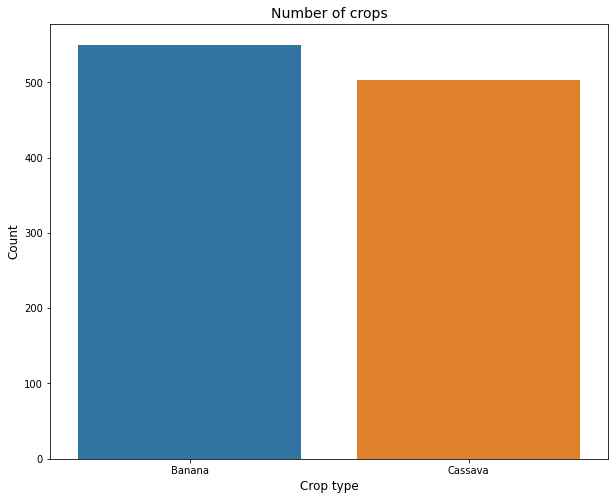

In [7]:
# Get the counts for each class
crops_count = crops_data['label'].value_counts()
print(crops_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=crops_count.index, y= crops_count.values)
plt.title('Number of crops', fontsize=14)
plt.xlabel('Crop type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(crops_count.index)), ['Banana', 'Cassava'])
plt.show()

In [8]:
# Define path to the data directory

# import splitfolders
# base_path = r'/content/drive/MyDrive/computer_vision_exam/cropped/'
# base_path = pathlib.Path(base_path)
# splitfolders.ratio(base_path, output='/content/drive/MyDrive/computer_vision_exam/splitset/learningset', seed=123, ratio=(0.8, 0.2),
#                   group_prefix=None)

In [9]:
data_dir = Path('/content/drive/MyDrive/computer_vision_exam/splitset/learningset/Train')

In [10]:
Banana = data_dir/'Banana'

Cassava = data_dir/'Cassava'

In [11]:
Bananas_samples = Banana.glob('*.jpg')
Cassava_samples = Cassava.glob('*.jpg')

In [12]:
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all Bananas. The label for Bananas will be 0/B
for img in Bananas_samples:
    train_data.append((img,'B'))

# Go through all Cassava. The label for Cassava will be 1/C
for img in Cassava_samples:
    train_data.append((img, 'C'))


# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,/content/drive/MyDrive/computer_vision_exam/sp...,B
1,/content/drive/MyDrive/computer_vision_exam/sp...,B
2,/content/drive/MyDrive/computer_vision_exam/sp...,B
3,/content/drive/MyDrive/computer_vision_exam/sp...,C
4,/content/drive/MyDrive/computer_vision_exam/sp...,C


B    440
C    402
Name: label, dtype: int64


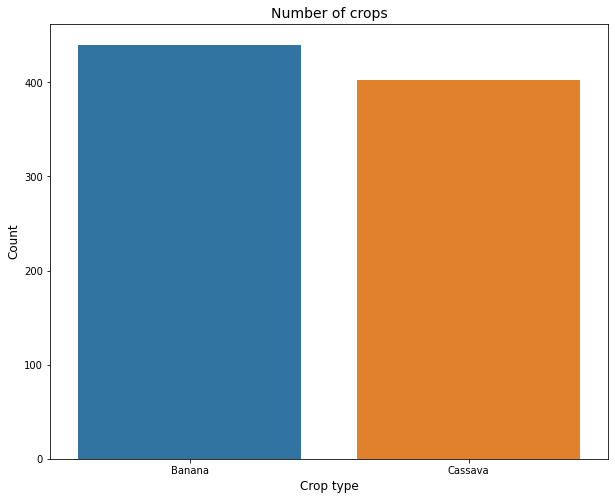

In [13]:
# Get the counts for each class
crops_count = train_data['label'].value_counts()
print(crops_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=crops_count.index, y= crops_count.values)
plt.title('Number of crops', fontsize=14)
plt.xlabel('Crop type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(crops_count.index)), ['Banana', 'Cassava'])
plt.show()

## Extract image features

### Methods

In [14]:
def getYourPlants(plants, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Train', 'Test']
    if not k_fold:
        path = "/content/drive/MyDrive/computer_vision_exam/splitset/learningset/" + data_type + "/"
        for i,f in enumerate(plants):
            p = path + f
            j=0
            for image_path in glob.glob(os.path.join(p, "*.jpg")):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (dim, dim))
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                images.append(image)
                labels.append(i)
                j+=1
            if(print_n):
                print("There are " , j , " " , data_type.upper(), " images of " , plants[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            path = "/content/drive/MyDrive/computer_vision_exam/splitset/learningset/" + v + "/"
            for i,f in enumerate(plants):
                p = path + f
                j=0
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j+=1
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    
def getAllPlants():
    plants = []
    for plant_path in glob.glob("/content/drive/MyDrive/computer_vision_exam/splitset/learningset/Train/*"):
        plant = plant_path.split("/")[-1]
        plants.append(plant)
    return plants

### Train Text dataset preparation and pixel extraction

In [15]:
#Plant Labels
plants = ['Banana' , 'Cassava'] #Binary classification

#Get Images and Labels 
X_t, y_train =  getYourPlants(plants, 'Train', print_n=True, k_fold=False)
X_test, y_test = getYourPlants(plants, 'Test', print_n=True, k_fold=False)

#Get data for k-fold
X,y = getYourPlants(plants, '', print_n=True, k_fold=True)

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_t])
X_test = scaler.fit_transform([i.flatten() for i in X_test])
X = scaler.fit_transform([i.flatten() for i in X])

There are  440   TRAIN  images of  BANANA
There are  402   TRAIN  images of  CASSAVA
There are  110   TEST  images of  BANANA
There are  101   TEST  images of  CASSAVA


### Exploration of Array Datasets

In [16]:
X_t

array([[[[200, 213, 221],
         [226, 239, 247],
         [218, 227, 236],
         ...,
         [ 18,  32,  43],
         [ 18,  32,  43],
         [ 18,  32,  43]],

        [[137, 150, 158],
         [179, 192, 198],
         [217, 227, 236],
         ...,
         [ 18,  32,  43],
         [ 18,  32,  43],
         [ 18,  32,  43]],

        [[ 95, 110, 115],
         [119, 133, 136],
         [166, 179, 185],
         ...,
         [ 18,  32,  43],
         [ 18,  32,  43],
         [ 18,  32,  43]],

        ...,

        [[ 26,  47,  52],
         [ 26,  47,  52],
         [ 27,  47,  54],
         ...,
         [217, 228, 234],
         [217, 228, 234],
         [218, 229, 235]],

        [[ 21,  40,  46],
         [ 23,  42,  48],
         [ 26,  45,  52],
         ...,
         [217, 228, 234],
         [217, 228, 234],
         [218, 229, 235]],

        [[ 31,  50,  56],
         [ 31,  50,  56],
         [ 31,  50,  57],
         ...,
         [217, 228, 234],
        

In [17]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [18]:
X_t.shape

(842, 224, 224, 3)

In [19]:
y_train.shape

(842,)

In [20]:
X_train.shape

(842, 150528)

In [21]:
X_train

array([[ 0.96690727,  1.00591425,  1.05179637, ...,  1.70141629,
         1.70349998,  1.72301195],
       [-0.94929254, -1.00371896, -0.82113896, ..., -0.78425582,
        -0.84619594, -0.75153352],
       [-0.94929254, -0.91774535, -0.83099652, ..., -0.80949107,
        -0.87107102, -0.93315153],
       ...,
       [-1.05755242, -1.07894587, -1.07743538, ..., -0.68331482,
        -0.63475774, -0.63802226],
       [ 0.44725986,  0.53305938,  0.20404669, ..., -0.5192857 ,
        -0.52281987, -0.63802226],
       [ 1.33499085,  1.26383509,  1.29823523, ...,  1.44906379,
         1.4671867 ,  1.4392338 ]])

In [22]:
X

array([[ 1.02085826,  1.05855474,  1.10718934, ...,  1.74737522,
         1.74820993,  1.77320783],
       [-0.92373352, -0.98326366, -0.79584733, ..., -0.77380235,
        -0.83628311, -0.73626758],
       [-0.92373352, -0.89591314, -0.80586331, ..., -0.79939806,
        -0.86149768, -0.92044927],
       ...,
       [-0.9676791 , -0.96142603, -0.99616698, ...,  0.40360037,
         0.43705248,  0.27673166],
       [ 0.86704874,  0.85109726,  0.86680576, ...,  2.13131089,
         2.02557016,  2.00343493],
       [-0.91274713, -0.88499432, -0.91603912, ...,  0.39080252,
         0.63876901, -0.36790422]])

In [23]:
X.shape

(1053, 150528)

In [24]:
y.shape

(1053,)

In [25]:
y

array([0, 0, 0, ..., 1, 1, 1])

## Plot Images

In [26]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1  

Banana


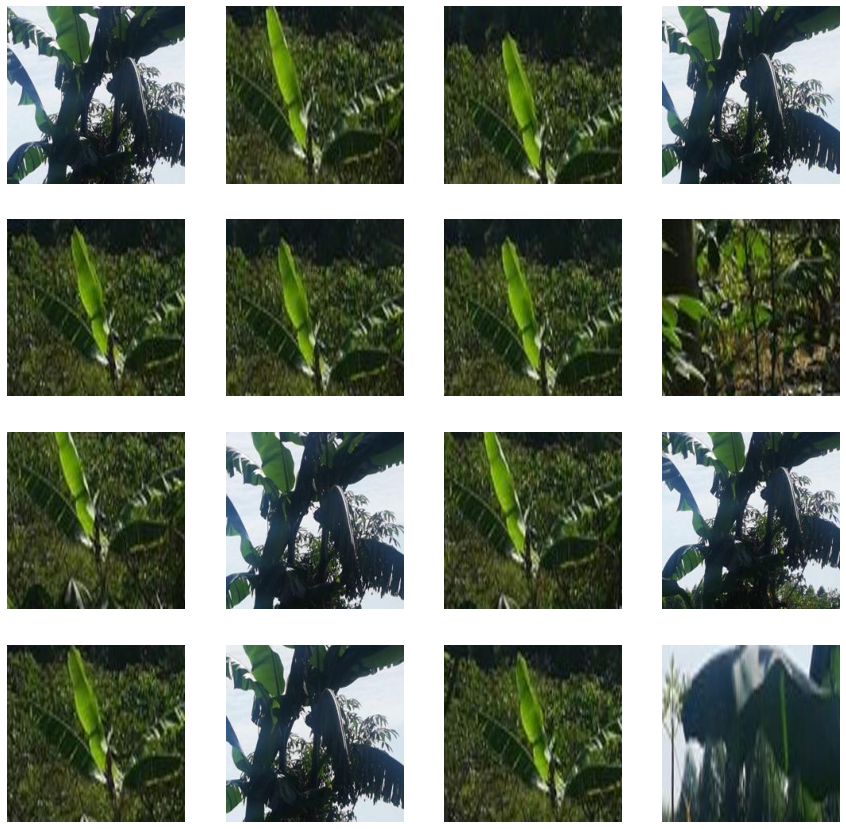

In [27]:
print(plants[y_train[0]])
plot_image_grid(X_t[0:16], 4, 4)

Cassava


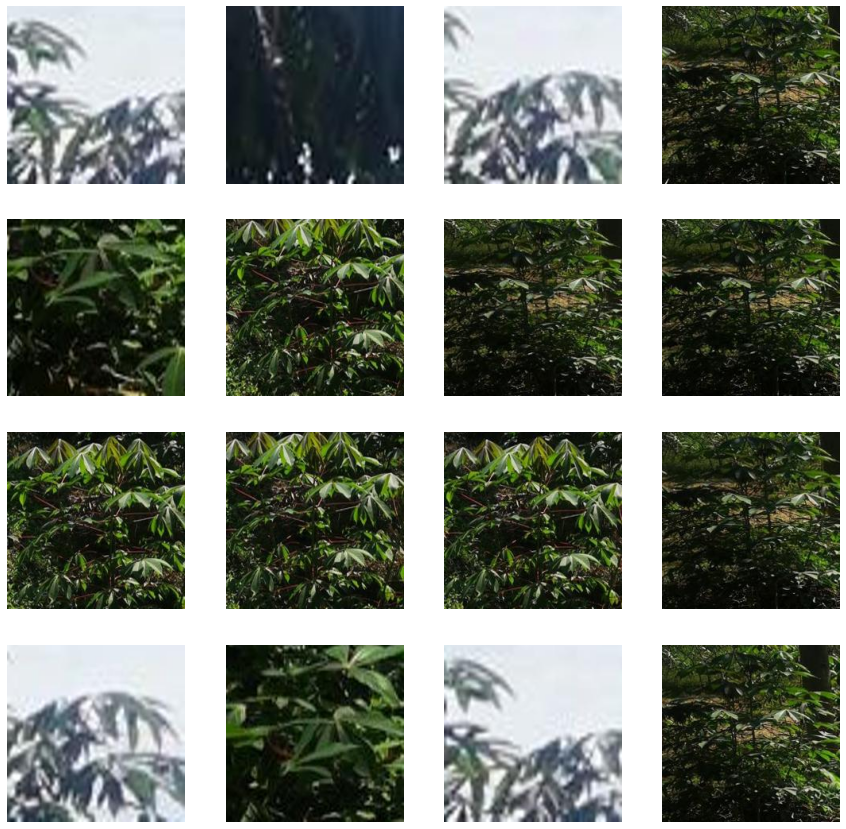

In [28]:
print(plants[y_train[490]])
plot_image_grid(X_t[490:506], 4, 4)

## Dimensionality and Model Classification using KNN

### Methods

In [29]:
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)        
    return v

def plotPrincipalComponents(X, dim):
    v = getClassNumber(y_train)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd']
    tot = len(X)
    start = 0 
    if(dim == 2):
        for i,index in enumerate(v):
            end = start + index
            plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = plants[i])
            start = end
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    if(dim == 3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i,index in enumerate(v):
            end = start + index
            ax.scatter(X[start:end,0], X[start:end,1], X[start:end,2], color=colors[i%len(colors)], marker=markers[i%len(markers)], label = plants[i])
            start = end
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')


    plt.legend(loc='lower left')
    plt.xticks()
    plt.yticks()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=plants, yticklabels=plants,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm,ax

### PCA and Variance

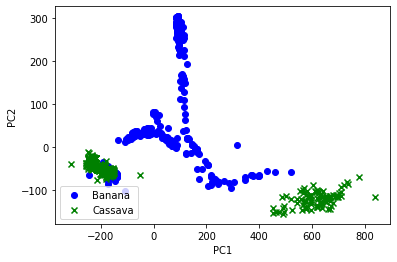

In [30]:
pca = PCA(n_components=2)
dataIn2D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn2D, 2)

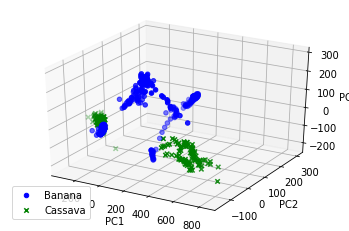

In [31]:
pca = PCA(n_components=3)
dataIn3D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn3D, 3)

In [32]:
def showPCA(image,X2, X10, X50):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,4,1)
    ax1.axis('off')
    ax1.set_title('Original image')
    plt.imshow(image)
    ax1 = fig.add_subplot(1,4,2)
    ax1.axis('off') 
    ax1.set_title('50 PC')
    plt.imshow(X50)
    ax1 = fig.add_subplot(1,4,3)
    ax1.axis('off') 
    ax1.set_title('10 PC')
    plt.imshow(X10)
    ax2 = fig.add_subplot(1,4,4)
    ax2.axis('off') 
    ax2.set_title('2 PC')
    plt.imshow(X2)
    plt.show()

def computePCA(n, im_scaled, image_id):
    pca = PCA(n)
    principalComponents = pca.fit_transform(im_scaled)
    im_reduced = pca.inverse_transform(principalComponents)
    newImage = scaler.inverse_transform(im_reduced[image_id])
    return newImage

def showVariance(X_train):
    #Compute manually the principal components
    cov_matr=np.dot(X_train, X_train.T)
    eigval,eigvect=np.linalg.eig(cov_matr)

    index=np.argsort(eigval)[::-1] #take in order the index of ordered vector (ascending order)

    #eigvect[:,i] is associated to eigval[i] so 
    eigvect=eigvect[:,index]
    eigval=eigval[index]

    n_PC=[]
    var_explained=[]
    var_temp=[]
    var_tmp=0
    for i in range(10):
        var_tmp=var_tmp+eigval[i]
        n_PC.append(i)
        var_temp.append(eigval[i]/(eigval.sum())*100)
        var_explained.append(var_tmp/(eigval.sum())*100)

    fig, ax = plt.subplots(figsize=(8,8))

    ind = np.arange(10)    
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, var_temp, width, color='b')
    p2 = ax.bar(ind + width, var_explained, width, color='r')

    ax.legend((p1[0], p2[0]), ('Individual explained variance', 'Cumulative explained variance'))

    ax.set_title('Variance explained using PCs')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))

    plt.xlabel('Number of PC')
    plt.ylabel('Variance exaplained in %')

    ax.autoscale_view()

    plt.show()

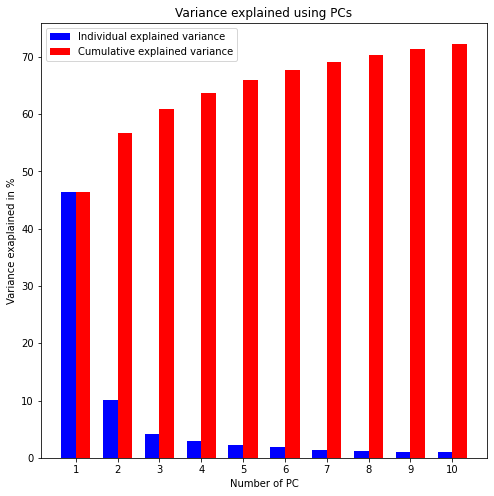

In [33]:
showVariance(X_train)

### KNN Model and Peformance Metrics

Accuracy with K-NN: 97.16%


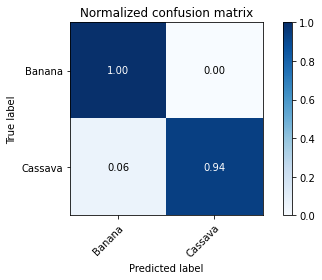

In [34]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = knn.predict_proba(X_test)
probs = probs[:, 1]
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_test, probs)
knn_auc = metrics.roc_auc_score(y_test, probs)

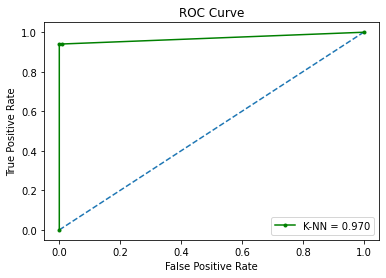

In [35]:
#ROC CURVE
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(knn_fpr, knn_tpr, 'g', marker='.', label = 'K-NN = %0.3f' % knn_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Save model

In [36]:
import pickle 
  
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(knn)

In [37]:
knn_save_model = 'knn_model_crop_classification.sav'
pickle.dump(knn, open(knn_save_model, 'wb'))

In [38]:
#KNN + K-FOLD
pred_kfold = cross_val_score(knn, X, y, cv=5) 
print("Accuracy with K-NN and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2))

Accuracy with K-NN and K-FOLD CROSS VALIDATION: 0.98 (+/- 0.03)


#### KNN with different K Neighbors(N)

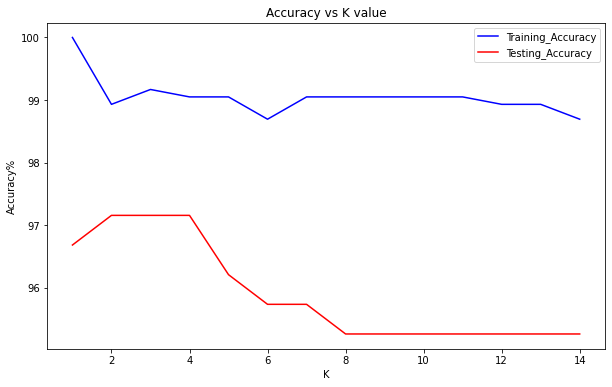

In [39]:
#CHANGING VALUES OF N
accuracy_train = []
accuracy_test = []

for i in range(1,15):   #check all possible values for 1 to 15
    k_nn = KNeighborsClassifier(n_neighbors=i)
    k_nn.fit(X_train,y_train)
    pred_i = k_nn.predict(X_test)
    accuracy_train.append(k_nn.score(X_train,y_train)*100)
    accuracy_test.append(k_nn.score(X_test,y_test)*100)
    
accuracy_train_array=np.asarray(accuracy_train)
accuracy_test_array=np.asarray(accuracy_test)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,15),accuracy_train_array, label='Training_Accuracy', color='blue')
plt.plot(range(1,15),accuracy_test_array, label='Testing_Accuracy', color='red')
plt.legend()
plt.title('Accuracy vs K value')
plt.xlabel('K')
plt.ylabel('Accuracy%')

plt.show()

#### Metrics for different KNNS

Accuracy with K-NN: 95.73%


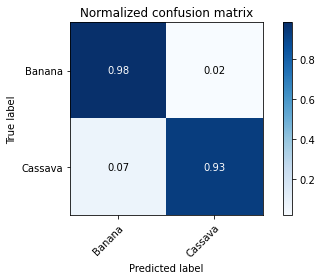

In [40]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = knn.predict_proba(X_test)
probs = probs[:, 1]
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_test, probs)
knn_auc = metrics.roc_auc_score(y_test, probs)

Accuracy with K-NN: 96.21%


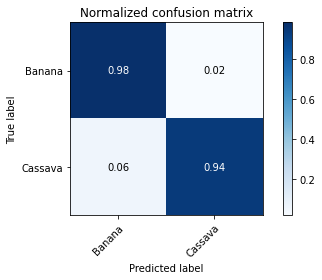

In [41]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = knn.predict_proba(X_test)
probs = probs[:, 1]
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_test, probs)
knn_auc = metrics.roc_auc_score(y_test, probs)

In [42]:
#KNN + K-FOLD
pred_kfold = cross_val_score(knn, X, y, cv=5) 
print("Accuracy with K-NN and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2))

Accuracy with K-NN and K-FOLD CROSS VALIDATION: 0.98 (+/- 0.02)


#### KNN with different PCA components

In [43]:
pca = PCA(n_components=2)
X_train2D = pca.fit_transform(X_train)
X_test2D = pca.fit_transform(X_test)

Accuracy with K-NN considering only first 2PC: 91.00%


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


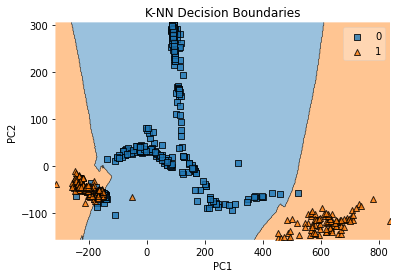

In [44]:
#K-NN + PCA
knn.fit(X_train2D, y_train)
y_pred = knn.predict(X_test2D)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN considering only first 2PC: {0:.2f}%".format(precision))

#Plotting decision boundaries
plot_decision_regions(X_train2D, y_train, clf=knn, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-NN Decision Boundaries')
plt.show()

Accuracy with K-NN: 91.00%


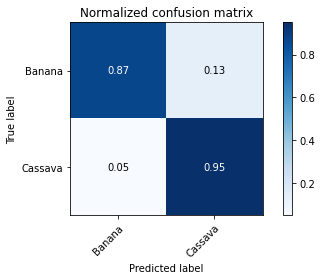

In [45]:
knn.fit(X_train2D, y_train)
y_pred = knn.predict(X_test2D)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = knn.predict_proba(X_test2D)
probs = probs[:, 1]
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_test, probs)
knn_auc = metrics.roc_auc_score(y_test, probs)

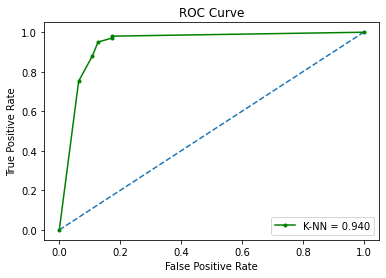

In [46]:
#ROC CURVE
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(knn_fpr, knn_tpr, 'g', marker='.', label = 'K-NN = %0.3f' % knn_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()